In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from resources.conv_learner import * # important because our ResNet name needs to override theirs
from resources.plots import *
from common import Statistics, dataset_source
from models import ResNet

In [3]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200
SEED = 5
# set the seeds for experimentation
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
stats_name = "yeast_v5_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT
working on: mmm1KO_230
working on: num1_110


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


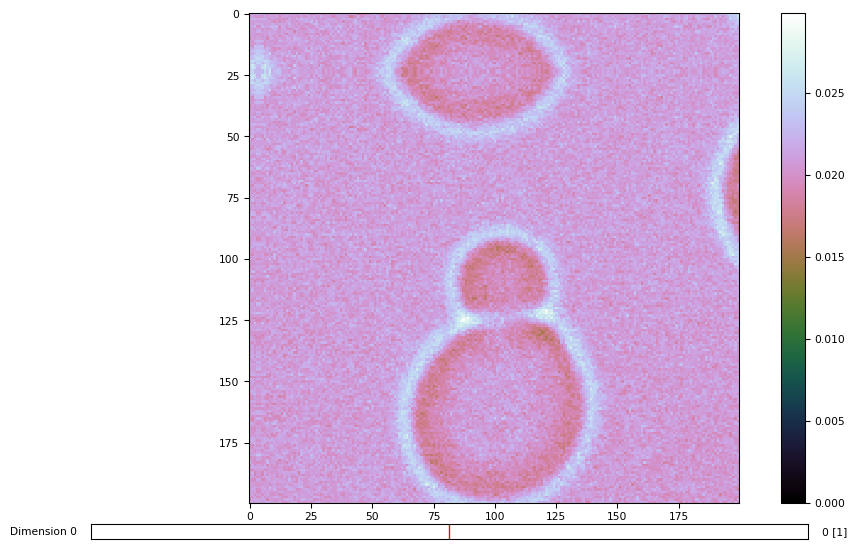

In [10]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

## ResNet_with_Batchnorm

In [29]:
import torch, torch.nn as nn, torch.nn.functional as F
from tensorboardX import SummaryWriter
from datetime import datetime
import os

class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3,log=False):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf, 1, 1))
        self.m = nn.Parameter(torch.ones(nf, 1, 1))
        self.logs = []
        self.log = log
        if log: print('logging')

    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:, None, None]
            self.stds = x_chan.std(1)[:, None, None]
        self.result = (x - self.means) / self.stds * self.m + self.a # for hook purposes
        return self.result

class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

class ResNet(nn.Module):
    def __init__(self, layers, num_classes, obj_name, exp_name="default", tb_log=True,log=True):
        """

        :param layers:
        :param num_classes:
        :param obj_name: like 'C', 'A'
        :param tb_log: boolean; if true then log to tensorboard
        :param exp_name: for example "v5_per_class" as in training on yeast_v5 with per class normalization
        """
        self.arch = f"ResNet{len(layers)}"
        date = datetime.now().strftime("%m-%d_%H-%M")
        self.tag = f"{self.arch}_{exp_name}_{date}"

        if tb_log:
            base_dir = './results/'+'tensorboardx/'
            if not os.path.isdir(base_dir): os.makedirs(base_dir)
            self.writer = SummaryWriter(base_dir+obj_name+'/'+self.tag)

        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
                                     for i in range(len(layers) - 1)])

        self.layers2 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], 1)
                                      for i in range(len(layers) - 1)])

        self.layers3 = nn.ModuleList([ResnetLayer(layers[i + 1], layers[i + 1], 1)
                                      for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], num_classes)
        self.log = log
        if log:self.logs = []
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        if self.log: self.logs.append(x)
        return F.log_softmax(self.out(x), dim=-1)

In [30]:
sorted(os.listdir(PATH+'/models'))

['Objective_A_Resnet_per_class_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_2.h5',
 'Objective_C_Resnet_per_class_3.h5',
 'Objective_C_Resnet_per_class_balanced_1.h5',
 'Objective_C_Resnet_per_dataset_2.h5',
 'Objective_C_Resnet_per_dataset_3.h5',
 'ResNet5_default_07-24_23-18.h5',
 'ResNet5_default_07-25_15-38.h5',
 'ResNet5_default_07-25_15-38.h5_2',
 'ResNet5_default_07-25_15-38.h5_88acc',
 'ResNet5_default_07-25_15-38.h5adjust_45',
 'ResNet5_default_07-25_15-55.h5',
 'ResNet5_default_07-25_15-55.h5_adj45',
 'ResNet5_v5_batch_adj_07-24_16-46.h5',
 'ResNet5_v5_batch_adj_07-24_18-32.h5',
 'ResNet5_v5_batch_adj_07-24_18-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-11.h5',
 'ResNet5_v5_batch_adj_07-24_19-32.h5',
 'ResNet5_v5_batch_adj_07-24_19-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-59.h5',
 'ResNet5_v5_batch_adj_07-24_20-27.h5',
 'ResNet5_v5_batch_adj_07-25_13-31.h5']

In [40]:
model = ResNet([10, 20, 40, 80, 160], 6, obj_name="embeddings", tb_log=True)
learn = ConvLearner.from_model_data(model, data)

In [41]:
learn.load('ResNet5_default_07-24_23-18')

In [42]:
learn.warm_up(1e-3)

EPOCH 0 ---------------------------------------- STEP 2    
mean: [21.61905 21.19048  5.      14.2381  29.95238  5.19048]; stdev: [5.68604 4.10132 3.35233 3.39334 6.49891 2.61168]

[WT]: 81.43%
[mfb1KO]: 95.71%
[mfb1KO_mmr1KO]: 88.57%
[mmm1KO_230]: 91.43%
[mmr1KO]: 85.71%
[num1_110]: 94.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.226443   0.567109   0.888889  
f1 weighted average score: [0.89]



[array([0.56711]), 0.8888888839691405]

In [43]:
learn.model.logs = []

In [44]:
predict_with_targs(learn.model,data.val_dl)

(array([[  -0.02157,   -6.5261 ,  -17.42111,  -96.63706,   -3.91843,  -14.89588],
        [  -0.01409,   -4.72524,  -46.24664, -245.11371,   -5.27353,  -38.20022],
        [  -0.08085,   -6.09433,  -50.93184, -265.1692 ,   -2.58475,  -41.22802],
        ...,
        [ -14.18211,  -16.90768,   -3.59403,  -41.57261,  -13.74713,   -0.02787],
        [  -9.56795,  -14.13856,   -1.98237,  -45.61296,  -12.00251,   -0.14829],
        [ -11.27662,  -20.5231 ,   -4.57977,  -43.05336,  -16.88884,   -0.01032]], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 

In [45]:
stack = torch.cat(learn.model.logs)

In [56]:
stack = stack.data.cpu()

In [48]:
xs = np.array([x.cpu().numpy() for x, y in data.val_dl])
xs = np.concatenate(xs)
xs = torch.from_numpy(xs)

In [49]:
ys = np.array([y.cpu().numpy() for x, y in data.val_dl])
ys = np.concatenate(ys)
ys = torch.from_numpy(ys)

In [50]:
zeros = torch.zeros(315,1,200,200)

In [57]:
type(stack)

torch.FloatTensor

In [59]:
rgb_xs = torch.cat((zeros, xs), 1)

In [60]:
learn.model.writer.add_embedding(stack, ys, rgb_xs, 100, tag='last layer')

In [ ]:
type(smt)